In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON

py.init_notebook_mode()

For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from [here](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page). Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.

In [2]:
# Code to read in v17, column names have been updated (without upper case letters) for v18

# bk = pd.read_csv('PLUTO17v1.1/BK2017V11.csv')
# bx = pd.read_csv('PLUTO17v1.1/BX2017V11.csv')
# mn = pd.read_csv('PLUTO17v1.1/MN2017V11.csv')
# qn = pd.read_csv('PLUTO17v1.1/QN2017V11.csv')
# si = pd.read_csv('PLUTO17v1.1/SI2017V11.csv')

# ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)

ny = pd.read_csv('pluto_20v1.csv')


# Getting rid of some outliers
ny = ny[(ny['yearbuilt'] > 1850) & (ny['yearbuilt'] < 2020) & (ny['numfloors'] != 0)]

C:\Users\traveler\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning:

Columns (17,18,20,22) have mixed types. Specify dtype option on import or set low_memory=False.



I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [4]:


# wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
# nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
# ny['xcoord'] = 0.3048*ny['xcoord']
# ny['ycoord'] = 0.3048*ny['ycoord']
# ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['xcoord'].values, ny['ycoord'].values)

# ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Part 1: Binning and Aggregation

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and [2D histograms](https://plot.ly/python/2D-Histogram/) (also check out their close relatives: [2D density plots](https://plot.ly/python/2d-density-plots/) and the more general form: [heatmaps](https://plot.ly/python/heatmaps/).

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [5]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('yearbuilt').count()['bbl'].index,
    y = ny.groupby('yearbuilt').count()['bbl']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.FigureWidget(data = [trace], layout = layout)

fig

py.iplot(fig)

Something looks off... You're going to have to deal with this imperfect data to answer this first question. 

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

---

Hello all, here are some pandas tips to help you guys through this homework:

[Indexing and Selecting](https://pandas.pydata.org/pandas-docs/stable/indexing.html): .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr

[Group By](https://pandas.pydata.org/pandas-docs/stable/groupby.html):  This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a [reset_index()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html).

[Reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html): I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.

Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a [huge section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) on datetime indexing. In particular, check out [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html), which provides time series specific aggregation.

[Merging, joining, and concatenation](https://pandas.pydata.org/pandas-docs/stable/merging.html): There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.

Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling")

Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.

---

### Question

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

In [6]:
# Start your answer here, inserting more cells as you go along

ny.columns

Index(['borough', 'block', 'lot', 'cd', 'ct2010', 'cb2010', 'schooldist',
       'council', 'zipcode', 'firecomp', 'policeprct', 'healtharea',
       'sanitboro', 'sanitsub', 'address', 'zonedist1', 'zonedist2',
       'zonedist3', 'zonedist4', 'overlay1', 'overlay2', 'spdist1', 'spdist2',
       'spdist3', 'ltdheight', 'splitzone', 'bldgclass', 'landuse',
       'easements', 'ownertype', 'ownername', 'lotarea', 'bldgarea', 'comarea',
       'resarea', 'officearea', 'retailarea', 'garagearea', 'strgearea',
       'factryarea', 'otherarea', 'areasource', 'numbldgs', 'numfloors',
       'unitsres', 'unitstotal', 'lotfront', 'lotdepth', 'bldgfront',
       'bldgdepth', 'ext', 'proxcode', 'irrlotcode', 'lottype', 'bsmtcode',
       'assessland', 'assesstot', 'exempttot', 'yearbuilt', 'yearalter1',
       'yearalter2', 'histdist', 'landmark', 'builtfar', 'residfar', 'commfar',
       'facilfar', 'borocode', 'bbl', 'condono', 'tract2010', 'xcoord',
       'ycoord', 'latitude', 'longitude', '

In [7]:
ny.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811684 entries, 0 to 859171
Data columns (total 99 columns):
borough                 811684 non-null object
block                   811684 non-null int64
lot                     811684 non-null int64
cd                      811384 non-null float64
ct2010                  811384 non-null float64
cb2010                  811384 non-null float64
schooldist              811341 non-null float64
council                 811384 non-null float64
zipcode                 811328 non-null float64
firecomp                811339 non-null object
policeprct              811341 non-null float64
healtharea              811341 non-null float64
sanitboro               811321 non-null float64
sanitsub                811252 non-null object
address                 811684 non-null object
zonedist1               811188 non-null object
zonedist2               17421 non-null object
zonedist3               119 non-null object
zonedist4               4 non-null objec

In [8]:
ny.head

<bound method NDFrame.head of        borough  block  lot     cd   ct2010  cb2010  schooldist  council  \
0           BK    834   46  307.0   106.00  2001.0        20.0     38.0   
1           QN   4042  106  407.0   929.00  3000.0        25.0     19.0   
2           BK   4679   17  317.0   866.00  3002.0        18.0     41.0   
3           BK   7831    6  318.0   676.00  1002.0        22.0     46.0   
4           BK   7831    7  318.0   676.00  1002.0        22.0     46.0   
5           BK   7831    8  318.0   676.00  1002.0        22.0     46.0   
6           BK   7831    9  318.0   676.00  1002.0        22.0     46.0   
7           BK   7831   13  318.0   676.00  1002.0        22.0     46.0   
8           BK   8797   50  315.0   622.00  2005.0        22.0     48.0   
9           BK   7832   18  318.0   676.00  1003.0        22.0     46.0   
10          QN   2827   11  405.0   507.00  2005.0        24.0     30.0   
11          BX   4634   47  212.0   370.00  3002.0        11.0     12.

In [9]:
ny['yearbuilt'].describe()

count    811684.000000
mean       1941.003352
std          30.440113
min        1851.000000
25%        1920.000000
50%        1931.000000
75%        1960.000000
max        2019.000000
Name: yearbuilt, dtype: float64

In [10]:
ny['numfloors'].describe()

count    811684.000000
mean          2.457334
std           1.982234
min           0.100000
25%           2.000000
50%           2.000000
75%           2.500000
max         205.000000
Name: numfloors, dtype: float64

In [11]:
# let's look at distribution of buildings and floor numbers by year built since year 2000

yearbuilt = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


for i in yearbuilt:
    
    trace0 = go.Histogram(
        
        x = ny['numfloors'][ny['yearbuilt'] == i],
        
        nbinsx = 5
      )    

    fig = tools.make_subplots(rows = 1, cols = 1)
    
    fig.append_trace(trace0, 1, 1)
    
    py.iplot(fig, filename = i)
    
# majority stayed within 10 to 20 floors as expected and the data is highly skewed to the right

C:\Users\traveler\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [12]:
# let's dig deeper about the data by first making a copy
ny_subs = ny[['yearbuilt', 'numfloors', 'bbl']].copy()

# since the number of floor num is highly skewed to the right, let's apply a log 10 transformation
floors = ((np.ceil(ny_subs['numfloors']) - 1) // 10 * 10 + 1).astype(int) 

# initialize the bins 
ny_subs['bins'] = ['{0:03d} to {1:03d} Floors'.format(x, x +9) for x in floors]

ny_subs.describe()

yearbuilt      numfloors           bbl
count  811684.000000  811684.000000  8.116840e+05
mean     1941.003352       2.457334  3.521920e+09
std        30.440113       1.982234  1.018584e+09
min      1851.000000       0.100000  1.000020e+09
25%      1920.000000       2.000000  3.033400e+09
50%      1931.000000       2.000000  4.008880e+09
75%      1960.000000       2.500000  4.105230e+09
max      2019.000000     205.000000  5.080500e+09

In [13]:
# group by the columns of interest
col_select = ny_subs.groupby(['yearbuilt', 'bins', 'numfloors'])

# create a dataframe for just the floor numbers
ny_floors = pd.DataFrame()

# add a new column
ny_floors['count'] = col_select['numfloors'].count()

ny_floors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4640 entries, (1851.0, 001 to 010 Floors, 2.0) to (2019.0, 041 to 050 Floors, 49.0)
Data columns (total 1 columns):
count    4640 non-null int64
dtypes: int64(1)
memory usage: 61.9+ KB


In [14]:
# put everything back together
ny_subs2 = ny_floors.groupby(['yearbuilt', 'bins']).sum()['count'].unstack(level = -1, fill_value = 0)

# examine the new data frame - now it is easier to read, visualize (probably in heatmap)
ny_subs2.tail(10)

bins       001 to 010 Floors  011 to 020 Floors  021 to 030 Floors  \
yearbuilt                                                            
2010.0                  1112                 27                  3   
2011.0                  1301                 23                  3   
2012.0                  1387                 35                 16   
2013.0                  1281                 41                 11   
2014.0                  1535                 52                 16   
2015.0                  1644                 55                 19   
2016.0                  1608                 60                 23   
2017.0                  1775                 67                 21   
2018.0                  1491                 67                 20   
2019.0                  1230                 47                  9   

bins       031 to 040 Floors  041 to 050 Floors  051 to 060 Floors  \
yearbuilt                                                            
2010.0                     4                  2                  2   
2011.0                     3                  3                  0   
2012.0                     2                  3                  1   
2013.0                    12                  6                  1   
2014.0                     3                  3                  4   
2015.0                    12                  5                  4   
2016.0                    12                  6                  1   
2017.0                     8                  4                  5   
2018.0                    10                  4                  2   
2019.0                     7                  3                  0   

bins       061 to 070 Floors  071 to 080 Floors  081 to 090 Floors  \
yearbuilt                                                            
2010.0                     0                  0                  0   
2011.0                     0                  0                  0   
2012.0                     1                  0                  1   
2013.0                     0                  0                  3   
2014.0                     2                  0                  0   
2015.0                     6                 11                  1   
2016.0                     1                  1                  0   
2017.0                     3                  0                  0   
2018.0                     2                  0                  0   
2019.0                     0                  0                  0   

bins       101 to 110 Floors  111 to 120 Floors  201 to 210 Floors  
yearbuilt                                                           
2010.0                     0                  0                  0  
2011.0                     0                  0                  0  
2012.0                     0                  0                  0  
2013.0                     0                  0                  0  
2014.0                     0                  0                  0  
2015.0                     0                  0                  0  
2016.0                     0                  0                  0  
2017.0                     0                  0                  0  
2018.0                     0                  0                  0  
2019.0                     0                  0                  0

In [15]:
# let's visualize it together by using a stacked bar chart
# we can look at number of buildings built throughout all these years and the distribution of number of floors (log transformed)

df = [] 

for i in range(0, len(ny_subs2.columns)):
    
    trace = go.Bar(
        
        x = ny_subs2[ny_subs2.columns[i]].index,
        
        y = ny_subs2[ny_subs2.columns[i]],
        
        name=ny_subs2.columns[i]
    )
    
    df.append(trace) 
    
layout = go.Layout(
    
    xaxis = dict(title = 'Year Built'),
    
    yaxis = dict(title = '# Lots Built (Log-Transform)',
                 
                 showticklabels = False,
                 
                 type = "log"),
    
    barmode = 'stack'
    
)

fig = dict(data = df, layout = layout)

py.offline.iplot(fig)

In [ ]:
# I am very surprised that 1920 is supposed to be the start of Great Depression stands out among all decades by the number of lots built
# Besides, there's nothing between 120 and 200. The traditional strategy to bin buildings (every 10 floors) still works and makes sense to me

## Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [16]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['yearbuilt'], np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['numfloors'], np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

fig = go.FigureWidget(
    data = [
        go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['bbl'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
    ]
)

py.iplot(fig)

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook [Plotting Perils](https://anaconda.org/jbednar/plotting_pitfalls/notebook). 

Here is what the same plot would look like in datashader:



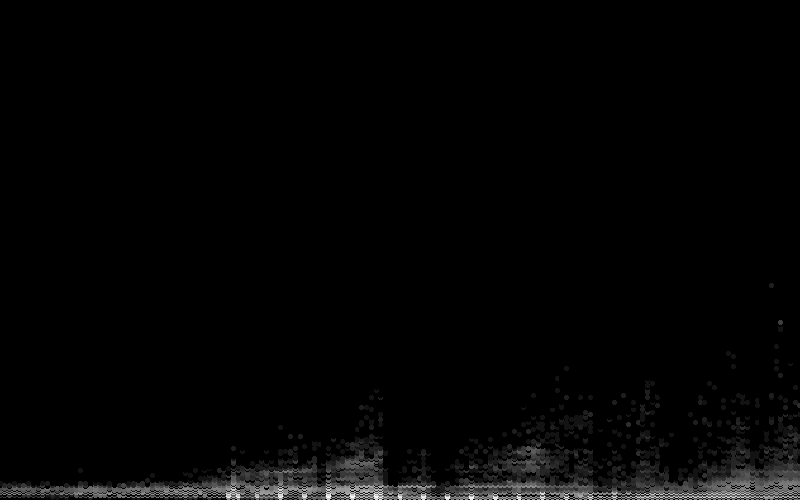

In [17]:
cvs = ds.Canvas(800, 500, x_range = (ny['yearbuilt'].min(), ny['yearbuilt'].max()), 
                                y_range = (ny['numfloors'].min(), ny['numfloors'].max()))
agg = cvs.points(ny, 'yearbuilt', 'numfloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

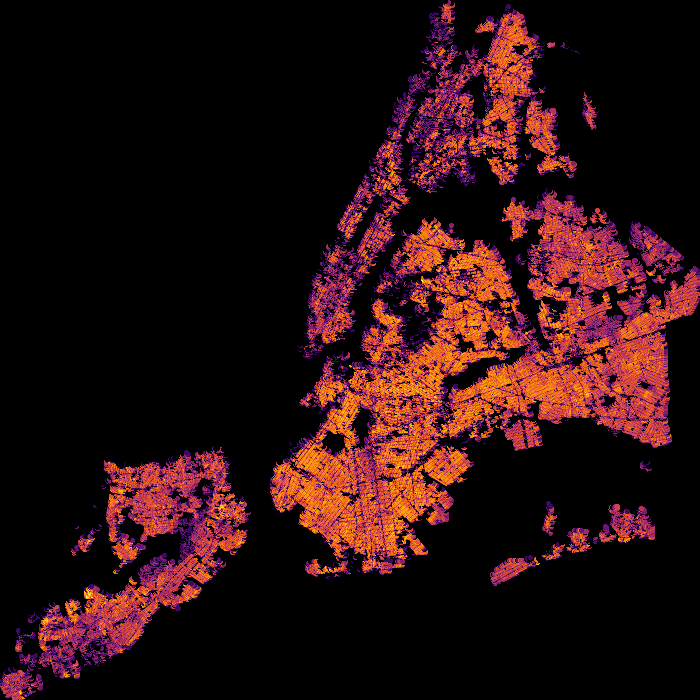

In [18]:
NewYorkCity   = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'xcoord', 'ycoord')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their [github repo](https://github.com/bokeh/datashader/tree/master/examples). I would focus on the [visualization pipeline](https://anaconda.org/jbednar/pipeline/notebook) and the [US Census](https://anaconda.org/jbednar/census/notebook) Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

### Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the [Pluto data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1), you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about [bivariate choropleth maps](http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

In [19]:
# let's see we can get value of building assessment from subtracting land from total assessment
ny['building_assessment'] = ny['assesstot'] - ny['assessland']

# let's look at the percentiles for land and building assessments (manually split into 10 and 90) and then look at the top tier
a10_percentile = np.percentile(ny['assessland'].values, 10)

a90_percentile = np.percentile(ny['assessland'].values, 90)

b10_percentile = np.percentile(ny['building_assessment'].values, 10)

b90_percntile = np.percentile(ny['building_assessment'].values, 90)

# partition by defined percentile definitions 
ny['aland_top_percentile'] = ny['assessland'].apply(lambda x: 1 if x < a10_percentile else 2 if x < a90_percentile else 3)

ny['astructure_top_percentile'] = ny['building_assessment'].apply(lambda x: 1 if x < b10_percentile else 2 if x < b90_percntile else 3)

ny['top_percentile_total'] = ny['aland_top_percentile'].apply(str) + ny['astructure_top_percentile'].apply(str) + 'c'

ny['top_percentile_total'] = pd.Categorical(ny['top_percentile_total'])

In [20]:
ny.describe()

block            lot             cd         ct2010  \
count  811684.000000  811684.000000  811384.000000  811384.000000   
mean     5329.737580     131.779919     355.074492     466.169032   
std      3671.886052     742.311334      99.613111     377.344031   
min         1.000000       1.000000     101.000000       1.000000   
25%      2369.000000      19.000000     307.000000     170.070000   
50%      4868.000000      38.000000     402.000000     358.000000   
75%      7505.000000      64.000000     412.000000     664.000000   
max     16350.000000    9450.000000     595.000000    9901.000000   

              cb2010     schooldist        council        zipcode  \
count  811384.000000  811341.000000  811384.000000  811328.000000   
mean     2055.935859      22.112144      32.138020   11019.950706   
std      1153.337828       7.893245      13.149692     466.904350   
min         1.000000       1.000000       1.000000   10001.000000   
25%      1004.000000      17.000000      23.000000   10466.000000   
50%      2001.000000      24.000000      32.000000   11222.000000   
75%      3000.000000      29.000000      44.000000   11370.000000   
max      9003.000000      32.000000      51.000000   12345.000000   

          policeprct     healtharea  ...  zoningdate  landmkdate  basempdate  \
count  811341.000000  811341.000000  ...         0.0         0.0         0.0   
mean       87.168915    3283.072644  ...         NaN         NaN         NaN   
std        29.094770    2674.281655  ...         NaN         NaN         NaN   
min         1.000000     100.000000  ...         NaN         NaN         NaN   
25%        66.000000     920.000000  ...         NaN         NaN         NaN   
50%       102.000000    2710.000000  ...         NaN         NaN         NaN   
75%       111.000000    4700.000000  ...         NaN         NaN         NaN   
max       123.000000    9300.000000  ...         NaN         NaN         NaN   

       masdate  polidate  edesigdate  notes  building_assessment  \
count      0.0       0.0         0.0  508.0         8.116840e+05   
mean       NaN       NaN         NaN    1.0         4.126351e+05   
std        NaN       NaN         NaN    0.0         7.106368e+06   
min        NaN       NaN         NaN    1.0         0.000000e+00   
25%        NaN       NaN         NaN    1.0         2.382000e+04   
50%        NaN       NaN         NaN    1.0         3.660000e+04   
75%        NaN       NaN         NaN    1.0         6.894000e+04   
max        NaN       NaN         NaN    1.0         3.924465e+09   

       aland_top_percentile  astructure_top_percentile  
count         811684.000000              811684.000000  
mean               2.000707                   2.000844  
std                0.446484                   0.446306  
min                1.000000                   1.000000  
25%                2.000000                   2.000000  
50%                2.000000                   2.000000  
75%                2.000000                   2.000000  
max                3.000000                   3.000000  

[8 rows x 74 columns]

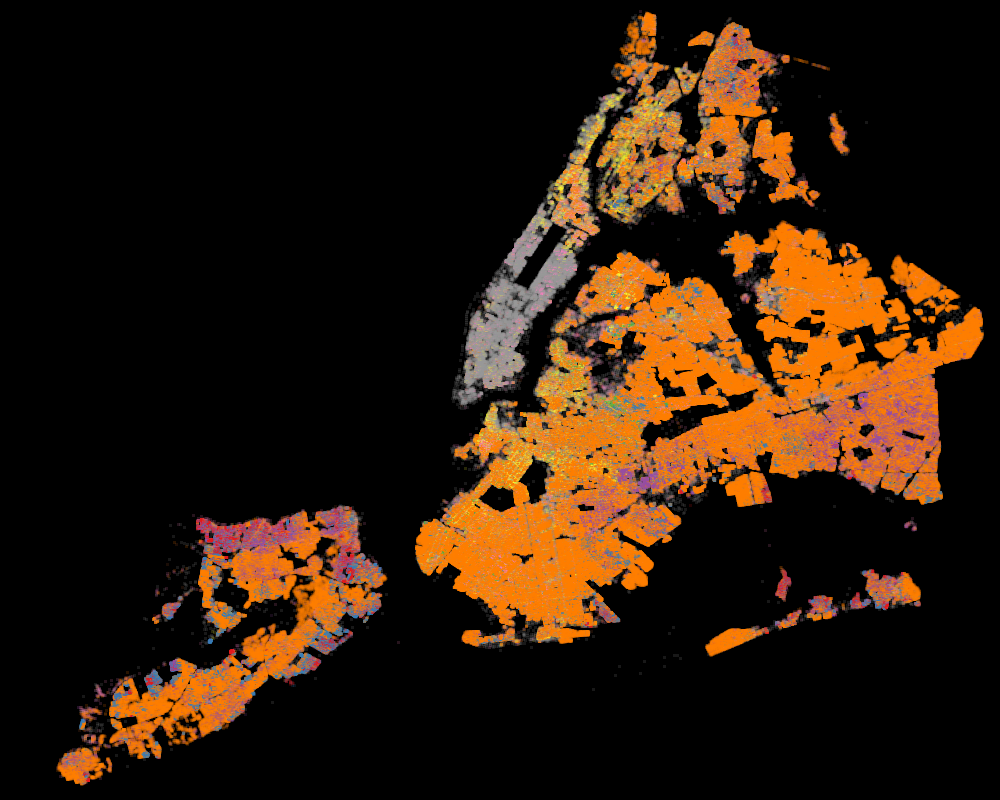

In [21]:
# nyc coordinates
nyc  = (( -74.29, -73.69), (40.49, 40.92))

cvs = ds.Canvas(1000, 800, *nyc)

agg = cvs.points(ny, 'longitude', 'latitude', ds.count_cat('top_percentile_total'))

view = tf.shade(agg)

# export(tf.spread(view, px=2), 'firery')

export(tf.spread(view, px = 1), 'bivariate')

# no surprise that Manhattan and downtown Brooklyn is high value and overdeveloped. Staten Island is the least desired. Brooklyn and Queens have great potential for future real estate development.